# **08 Predictive model**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* housing_cleaned.csv

## Outputs

* test_set.csv

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Baseline model

Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm


In [ ]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned.csv')
df.head(10)

---

In [ ]:
# test on the latest 20% of the data using the transfer_date
# sort the DataFrame by transfer_date
# convert to datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
# keep only the transfer_date for 2024 onwards
df = df[df['transfer_date'].dt.year >= 2024]

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression  # or Ridge

# set model features
num_feats   = ['log_total_floor_area','IMD_Rank','energy_band_num']
bin_feats   = ['new_build','is_leasehold']  # pass through as 0/1
cat_feats   = ['property_type','county']

# Control category order to set baselines via drop='first'
ptype_order = ['D','S','T','F']  # baseline becomes 'D' (Detached)
county_order = [
    'WEST MIDLANDS','WARWICKSHIRE','WORCESTERSHIRE','LEICESTERSHIRE',
    'LEICESTER','STAFFORDSHIRE','DERBYSHIRE','CITY OF DERBY','STOKE-ON-TRENT'
]  # baseline becomes WEST MIDLANDS

# Build the ColumnTransformer (code suggested by Copilot)
pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first',
                              categories=[ptype_order, county_order],
                              handle_unknown='ignore'),
         cat_feats),
        ('bin', 'passthrough', bin_feats),
    ],
    remainder='drop'
)

# End-to-end pipeline
pipe = Pipeline([
    ('pre', pre),
    ('model', LinearRegression())   # or Ridge()
])

# Fit
X = df[num_feats + bin_feats + cat_feats]
y = df['log_price']
pipe.fit(X, y)

# ---- Get feature names aligned to coefficients ----
num_names = np.array(num_feats)
cat_names = pipe.named_steps['pre'].named_transformers_['cat'].get_feature_names_out(cat_feats)
bin_names = np.array(bin_feats)
feature_names = np.concatenate([num_names, cat_names, bin_names])

coefs = pipe.named_steps['model'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'beta': coefs}) \
           .sort_values('beta', key=np.abs, ascending=False)

coef_df.head(20)

# convert beta coefficients back to original scale and back to price scale not just a pct change but a real change
# calculate the std dev of each feature in the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
pre_fitted = pipe.named_steps['pre']
X_train = pre_fitted.fit_transform(X_train)
X_test = pre_fitted.transform(X_test)
# get the std dev of each feature in the training set
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_train_std = X_train_df.std()

coef_df['std impact'] = coef_df['beta'] * X_train_std.values # std dev impact on log price
# convert to pct and price impact
coef_df['std_pct'] = coef_df['std impact'] / df['log_price'].std() * 100
coef_df['std_price'] = coef_df['std impact'] * df['price'].median()
coef_df['beta_pct'] = (np.exp(coef_df['beta']) - 1) * 100
coef_df['beta_price'] = (np.exp(coef_df['beta']) - 1) * df['price'].median()
coef_df = coef_df.sort_values('beta_price', key=np.abs, ascending=False)
print("\nTop coefficients (by |£ impact|):")
print(coef_df.head(30).to_string(index=False))


In [ ]:
# mean D price
df.groupby('property_type')['price'].mean().loc['D']
# std dev D price
df.groupby('property_type')['price'].std().loc['D']
print(df.groupby('property_type')['price'].std().loc['D']*0.207927)
print(f"Mean Detached price    : £{df.groupby('property_type')['price'].mean().loc['D']:.0f}")
print(f"Std Dev Detached price : £{df.groupby('property_type')['price'].std().loc['D']:.0f}")

In [ ]:
r2 = pipe.score(X, y)
print(f"R²: {r2:.3f}")

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm



In [ ]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned.csv')
df.head(10)
df.info()


In [ ]:
# Features
df = df.copy()

num_feats = ['log_total_floor_area','IMD_Rank','energy_band_num']
bin_feats = ['new_build','is_leasehold']               # 0/1 passthrough
cat_feats = ['property_type','county']                 # one-hot with explicit baselines

ptype_order  = ['D','S','T','F']  # Detached baseline (drop first)
county_order = ['WEST MIDLANDS','WARWICKSHIRE','WORCESTERSHIRE','LEICESTERSHIRE',
                'LEICESTER','STAFFORDSHIRE','DERBYSHIRE','CITY OF DERBY','STOKE-ON-TRENT']  # WEST MIDLANDS baseline

pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first',
                              categories=[ptype_order, county_order],
                              handle_unknown='ignore'), cat_feats),
        ('bin', 'passthrough', bin_feats),
    ],
    remainder='drop'
)


R² (log target): 0.737
MAE £ (plain back-transform):  50,330
RMSE £ (plain back-transform): 74,795
MAE £ (Duan smearing):         49,840
RMSE £ (Duan smearing):        73,226

Intercept (on log scale): 12.719750175591983

Top coefficients (by |beta|):
              feature      beta  pct_effect_vs_baseline
      property_type_F -0.475214              -37.824779
county_STOKE-ON-TRENT -0.347939              -29.385789
      property_type_T -0.322257              -27.548783
      property_type_S -0.210098              -18.949502
 log_total_floor_area  0.205054               22.759195
 county_CITY OF DERBY -0.189302              -17.246357
    county_DERBYSHIRE -0.180010              -16.473796
            new_build  0.149314               16.103711
 county_STAFFORDSHIRE -0.145960              -13.580759
county_LEICESTERSHIRE -0.124691              -11.723071
             IMD_Rank  0.117316               12.447520
  county_WARWICKSHIRE  0.028695                2.911040
county_WORCESTERSHIR

### Note: the following functions are custom functions to evaluate regression models provided by the Code Institute for their Data Analysis with AI course.

In [76]:
# what is in pre?
pre_fitted = pipe.named_steps['pre']
pre_fitted.get_feature_names_out()


array(['num__log_total_floor_area', 'num__IMD_Rank',
       'num__energy_band_num', 'cat__property_type_S',
       'cat__property_type_T', 'cat__property_type_F',
       'cat__county_WARWICKSHIRE', 'cat__county_WORCESTERSHIRE',
       'cat__county_LEICESTERSHIRE', 'cat__county_LEICESTER',
       'cat__county_STAFFORDSHIRE', 'cat__county_DERBYSHIRE',
       'cat__county_CITY OF DERBY', 'cat__county_STOKE-ON-TRENT',
       'bin__new_build', 'bin__is_leasehold'], dtype=object)

In [ ]:

# Train / Test split on random 80/20 split


X = df[num_feats + cat_feats + bin_feats]
y = df['log_price']  # log1p(price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model pipeline
pipeline = Pipeline([
    ('pre', pre),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)

from numpy import expm1

y_pred_log = pipeline.predict(X_test)

# R² on log target
r2_log = r2_score(y_test, y_pred_log)

# Back-transform to £ (plain)
y_test_gbp = expm1(y_test)
y_pred_gbp_plain = expm1(y_pred_log)
mae_gbp_plain  = mean_absolute_error(y_test_gbp, y_pred_gbp_plain)
rmse_gbp_plain = mean_squared_error(y_test_gbp, y_pred_gbp_plain, squared=False)

# Duan smearing (recommended for log models)
y_pred_train_log = pipe.predict(X_train)
res_log = y_train - y_pred_train_log
smear = np.mean(np.exp(res_log))  # compute on TRAIN only

# For log1p targets, the unbiased level is: np.exp(pred_log)*smear - 1
y_pred_gbp_smear = np.exp(y_pred_log) * smear - 1
mae_gbp_smear  = mean_absolute_error(y_test_gbp, y_pred_gbp_smear)
rmse_gbp_smear = mean_squared_error(y_test_gbp, y_pred_gbp_smear, squared=False)

print(f"R² (log target): {r2_log:.3f}")
print(f"MAE £ (plain back-transform):  {mae_gbp_plain:,.0f}")
print(f"RMSE £ (plain back-transform): {rmse_gbp_plain:,.0f}")
print(f"MAE £ (Duan smearing):         {mae_gbp_smear:,.0f}")
print(f"RMSE £ (Duan smearing):        {rmse_gbp_smear:,.0f}")

# ----------------------------------
# 5) Coefficients table (names aligned to transformed columns)
# ----------------------------------
pre_fitted = pipe.named_steps['pre']
lin        = pipe.named_steps['model']

num_names = np.array(num_feats)
cat_names = pre_fitted.named_transformers_['cat'].get_feature_names_out(cat_feats)
bin_names = np.array(bin_feats)
feature_names = np.concatenate([num_names, cat_names, bin_names])

coef = pd.Series(lin.coef_, index=feature_names)

coef_df = (pd.DataFrame({
            'feature': feature_names,
            'beta': coef.values,
            # % effect is most meaningful for unscaled log or dummy features; shown here for reference
            'pct_effect_vs_baseline': (np.exp(coef.values) - 1) * 100
          })
          .sort_values('beta', key=np.abs, ascending=False)
         )

print("\nTop coefficients (by |beta|):")
print(coef_df.head(30).to_string(index=False))

In [ ]:
# import regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
# we will use numpy to calculate RMSE based on MSE (mean_squared_error)
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Gets train/test sets and pipeline and evaluates the performance
    for each set (train and test) by calling regression_evaluation()
    which will evaluate the pipeline performance.

    Parameters:
    - X_train: The input features of the training set.
    - y_train: The target values of the training set.
    - X_test: The input features of the test set.
    - y_test: The target values of the test set.
    - pipeline: The regression pipeline to evaluate.

    Returns:
    None
    """

    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    
    Args:
        X (array-like): The input features.
        y (array-like): The target values.
        pipeline (object): The trained pipeline for regression.
    
    Returns:
        None
    
    Prints the following performance metrics comparing the prediction to the target:
    - R2 Score
    - Mean Absolute Error
    - Mean Squared Error
    - Root Mean Squared Error
    """
    prediction = pipeline.predict(X)
    print("R2 Score:", r2_score(y, prediction).round(3))
    print("Mean Absolute Error:", mean_absolute_error(y, prediction).round(3))
    print("Mean Squared Error:", mean_squared_error(y, prediction).round(3))
    print(
        "Root Mean Squared Error:", np.sqrt(mean_squared_error(y, prediction)).round(3)
    )
    print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    """
    Gets Train and Test set (features and target), pipeline, and adjusts dots transparency
    at scatter plot.

    Parameters:
    - X_train (array-like): Training set features.
    - y_train (array-like): Training set target.
    - X_test (array-like): Test set features.
    - y_test (array-like): Test set target.
    - pipeline (object): Trained regression pipeline.
    - alpha_scatter (float, optional): Transparency level for scatter plot dots. Default is 0.5.

    Returns:
    None

    Functionality:
    - Predicts on the train and test set using the provided pipeline.
    - Creates Actual vs Prediction scatterplots for the train and test set.
    - Draws a red diagonal line. In theory, a good regressor should predict
        close to the actual, meaning the dot should be close to the diagonal red line.
        The closer the dots are to the line, the better.
    - Displays the scatterplots.
    """
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color="red", ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color="red", ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Regression Model Performance 
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.685
Mean Absolute Error: 0.186
Mean Squared Error: 0.062
Root Mean Squared Error: 0.248


* Test Set
R2 Score: 0.741
Mean Absolute Error: 0.178
Mean Squared Error: 0.055
Root Mean Squared Error: 0.234


The train set Mean Absolute Error in GBP: 51,549
The test  set Mean Absolute Error in GBP: 49,888


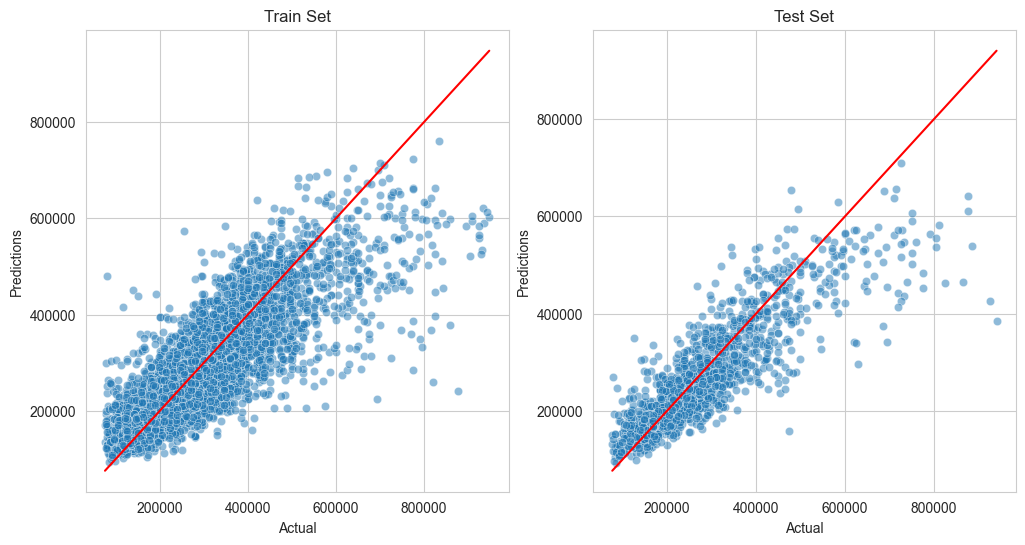

In [72]:
print("Regression Model Performance \nNote the MAE and MSE are in log(GBP) not GBP")
regression_performance(X_train, y_train, X_test, y_test, pipeline)

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae:,.0f}")

alpha_scatter=0.5
# change the actuals and predictions to GBP
y_train_gbp = expm1(y_train)
y_test_gbp = expm1(y_test)
y_pred_gbp = expm1(pipeline.predict(X_test))
y_pred_train = expm1(pipeline.predict(X_train))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.scatterplot(x=y_train_gbp, y=y_pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train_gbp, y=y_train_gbp, color="red", ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test_gbp, y=y_pred_gbp, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test_gbp, y=y_test_gbp, color="red", ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.show()


The performance on the train and test set is similarnot too different, indicating that the model didn't overfit.
At the same time, the test set performance (which is the best data to simulate real data since the model has never seen it) has an R2 performance of 0.74. 
This is a good R2 value for a baseline model.
We also note in the plots of Prediction x Actual, the predictions tend to follow the actual value. 
It is evident, however, that actual higher priced sold value properties are being undervalued. This needs further investigation.

In [ ]:
# save the test set for future evaluation
test = X_test.copy()
test['log_price'] = y_test
test.to_csv('../data/clean/test_set.csv', index=False)